## ML in a nutshell

Optimization, and machine learning, are intimately connected.  At a very coarse level, ML works as follows. 

First, you come up somehow with a very complicated model $\vec{y} = M(\vec{x}, \vec{\theta})$, which computes an output $\vec{y}$ as a function of an input $\vec{x}$ and of a vector of parameters $\vec{\theta}$.   In general, $\vec{x}$, $\vec{y}$, and $\vec{\theta}$ are vectors, as the model has multiple inputs, multiple outputs, and several parameters.  The model $M$ needs to be complicated, because only complicated models can represent complicated phenomena; for instance, $M$ can be a multi-layer neural net with parameters $\vec{\theta} = [\theta_1, \ldots, \theta_k]$, where $k$ is the number of parameters of the model. 

Second, you come up with a notion of _loss_ $L$, that is, how badly the model is doing.  For instance, if you have a list of inputs $\vec{x}_1, \ldots, \vec{x}_n$, and a set of desired outputs $\vec{y}_1, \ldots, \vec{y}_m$, you can use as loss: 

$$
L(\vec{\theta}) = \sum_{i=1}^n |\!|\vec{y}_i - M(\vec{x}_i, \vec{\theta})|\!| \; .
$$

Here, we wrote $L(\vec{\theta})$ because, once the inputs $\vec{x}_1, \ldots, \vec{x}_n$ and the desired outputs $\vec{y}_1, \ldots, \vec{y}_n$ are chosen, the loss $L$ depends on $\vec{\theta}$. 

Once the loss is chosen, you decrease it, by computing its _gradient_ with respect to $\vec{\theta}$.  Remembering that $\vec{\theta} = [\theta_1, \ldots, \theta_k]$,

$$
\nabla_\vec{\theta} L = \left[ \frac{\partial L}{\partial \theta_1}, \ldots, 
    \frac{\partial L}{\partial \theta_k} \right] \; .
$$

The gradient is a vector that indicates how to tweak $\vec{\theta}$ to decrease the loss.  You then choose a small _step size_ $\delta$, and you update $\vec{\theta}$ via $\vec{\theta} := \vec{\theta} - \delta \nabla_\vec{\theta} L$.  This makes the loss a little bit smaller, and the model a little bit better.  If you repeat this step many times, the model will hopefully get (a good bit) better. 

## Autogradient

The key to _pleasant_ ML is to focus on building the model $M$ in a way that is sufficiently expressive, and on choosing a loss $L$ that is helpful in guiding the optimization.  The computation of the gradient is done automatically for you.  This capability, called _autogradient_, is implemented in ML frameworks such as [Tensorflow](https://www.tensorflow.com), [Keras](https://keras.io), and [PyTorch](https://pytorch.org).  

It is possible to use these advanced ML libraries without ever knowing what is under the hood, and how autogradient works.  Here, we will insted dive in, and implement autogradient.  

Building a model $M$ corresponds to building an expression with inputs $\vec{x}$, $\vec{\theta}$.  We will provide a representaton for expressions that enables both the calculation of the expression value, and the differentiation with respect to any of the inputs.  This will enable us to implement autogradient.  On the basis of this, we will be able to implement a simple ML framework. 

We say we, but we mean you.  _You_ will implement it; we will just provide guidance.

## Expressions with autogradient

Our main task will be to implement a class `Expr` that represents expressions with autogradient.  

### Implementing expressions

We will have `Expr` be the abstract class of a generic expression, and `Plus`, `Multiply`, and so on, be derived classes representing expression with given top-level operators.  The constructor takes the children node.  The code for the constructor, and the code to create addition expressions, is as follows. 



In [42]:
class Expr(object):

    def __init__(self, *args):
        """Initializes an expression node, with a given list of children 
        expressions."""
        self.children = args
        self.value = None # The value of the expression. 
        self.values = None # The values of the child expressions.

    def __add__(self, other):
        """Constructs the sum of two expressions."""
        return Plus(self, other)

The code for the `Plus` class, initially, is empty; no `Expr` methods are over-ridden.

In [43]:
class Plus(Expr):
    """An addition expression."""

    pass

To construct expressions, we need one more thing.  So far, if we write things like `2 + 3`, Python will just consider these as expressions involving numbers, and compute their value.  To write _symbolic_ expressions, we need symbols, or variables.  A variable is a type of expression that just contains a value as child, and that has an `assign` method to assign a value to the variable.  The `assign` method can be used to modify the variable's content (without `assign`, our variables would be constants!). 

In [44]:
class V(Expr):
    """This class represents a variable.  The derivative rule corresponds 
    to d/dx x = 1, but note that it will not be called, since the children
    of a variable are just numbers."""

    def assign(self, v):
        """Assigns a value to the variable."""
        self.children = [v]

This suffices for creating expressions.  Let's create one.

In [45]:
e = V(3) + 4
e

In [46]:
# Let us ensure that nose is installed. 
try:
    from nose.tools import assert_equal, assert_true
    from nose.tools import assert_false, assert_almost_equal
except:
    !pip install nose
    from nose.tools import assert_equal, assert_true
    from nose.tools import assert_false, assert_almost_equal

## Computing the value of expressions

We now have our first expression.  To compute the expression value, we endow each expression with a method `op`, whose task is to compute the value `self.value` of the expression from the list of values `self.values` of the children.  

Let's implement the `compute` method for an expression.  This method will: 

1. Loop over the children, and computes the list `self.values` of children values as follows: 
    * If the child is an expression (an instance of `Expr`, obtain its value by calling `compute` on it. 
    * If the child is not an instance of `Expr`, then the child must be a number, and we can use its value directly. 
2. Call the method `op` of the expression, to compute `self.value` from `self.values`. 
3. return `self.value`. 

We will let you implement the `compute` method.  Hint: it takes just a couple of lines of code.

In [47]:
class Expr(object):

    def __init__(self, *args):
        """Initializes an expression node, with a given list of children 
        expressions."""
        self.children = args
        self.value = None # The value of the expression. 
        self.values = None # The values of the child expressions.
        self.gradient = 0 # The value of the gradient. 

    def op(self):
        """This operator must be implemented in subclasses; it should
        compute self.value from self.values, thus implementing the 
        operator at the expression node."""
        raise NotImplementedError()
        
    def compute(self):
        """This method computes the value of the expression. 
        It first computes the value of the children expressions,
        and then uses self.op to compute the value of the expression."""
        self.value = None ### INSERT YOUR SOLUTION HERE
        return self.value

    def __repr__(self):
        return ("%s:%r %r (g: %r)" % (
            self.__class__.__name__, self.children, self.value, self.gradient))
        
    # Expression constructors

    def __add__(self, other):
        return Plus(self, other)

    def __radd__(self, other):
        return Plus(self, other)

    def __sub__(self, other):
        return Minus(self, other)

    def __rsub__(self, other):
        return Minus(other, self)

    def __mul__(self, other):
        return Multiply(self, other)

    def __rmul__(self, other):
        return Multiply(other, self)

    def __truediv__(self, other):
        return Divide(self, other)

    def __rtruediv__(self, other):
        return Divide(other, self)

    def __pow__(self, other):
        return Power(self, other)

    def __rpow__(self, other):
        return Power(other, self)

    def __neg__(self):
        return Negative(self)

Let us give `op` for `Plus`, `Multiply`, and for variables via `V`, so you can see how it works.

In [48]:
class V(Expr):
    """This class represents a variable."""

    def assign(self, v):
        """Assigns a value to the variable.  Used to fit a model, so we
        can assign the various input values to the variable."""
        self.children = [v]

    def op(self):
        self.value = self.values[0]

    def __repr__(self):
        return "Variable: " + str(self.children[0])

        
class Plus(Expr):

    def op(self):
        self.value = self.values[0] + self.values[1]


class Multiply(Expr):

    def op(self):
        self.value = self.values[0] * self.values[1]

Here you can write your implementation of the `compute` method.

In [49]:
### Exercise: Implementation of `compute` method

def expr_compute(self):
    """This method computes the value of the expression. 
    It first computes the value of the children expressions,
    and then uses self.op to compute the value of the expression."""
    self.values = []  
    for x in self.children:
      try:
        self.values.append(x.compute())
      except:
        self.values.append(x)
    self.op()   
    return self.value

Expr.compute = expr_compute

In [50]:
### Tests for compute

from nose.tools import assert_equal, assert_true, assert_false

# First, an expression consisting only of one variable.
e = V(3)
assert_equal(e.compute(), 3)
assert_equal(e.value, 3)

# Then, an expression involving plus.
e = V(3) + 4
assert_equal(e.compute(), 7)
assert_equal(e.value, 7)

# And finally, a more complex expression.
e = (V(3) + 4) + V(2)
assert_equal(e.compute(), 9)
assert_equal(e.value, 9)


We will have you implement also multiplication.

In [51]:
### Exercise: Implement `Multiply`

class Multiply(Expr):
    """A multiplication expression."""

    def op(self):
      self.value = 1
      for x in self.values:
        self.value *=x
      return self.value


In [52]:
### Tests for `Multiply`

e = V(2) * 3
assert_equal(e.compute(), 6)

e = (V(2) + 3) * V(4)
assert_equal(e.compute(), 20)


## Implementing autogradient

The next step consists in implementing autogradient.  Consider an expression $e = E(x_0, \ldots, x_n)$, computed as function of its children expressions $x_0, \ldots, x_n$.  

The goal of the autogradient computation is to accumulate, in each node of the expression, the gradient of the loss with respect to the node's value.  For instance, if the gradient is $2$, we know that if we increase the value of the expression by $\Delta$, then the value of the loss is increased by $2 \Delta$. We accumulate the gradient in the field `self.gradient` of the expression. 

We say _accumulate_ the gradient, because we don't really do:

    self.gradient = ...

Rather, we have a method `e.zero_gradient()` that sets all gradients to 0, and we then _add_ the gradient to this initial value of 0: 

    self.gradient += ... 

We will explain later in detail why we do so; for the moment, just accept it. 

### Computaton of the gradient

In the computation of the autogradient, the expression will receive as input the value $\partial L / \partial e$, where $L$ is the loss, and $e$ the value of the expression.  The quantity $\partial L / \partial e$ is the gradient of the loss with respect to the expression value. 

With this input, the method `compute_gradient` of Expr must do the following:

* It must _add_ $\partial L / \partial e$ to the gradient `self.gradient` of the expression. 
* It must compute for each child $x_i$ the partial derivative $\partial e / \partial x_i$, via a call to the method `derivate`.  The method `derivate` is implemented not for `Expr`, but for each specific operator, such as `Plus`, `Multiply`, etc: each operator knows how to compute the derivative with respect to its arguments.
* It must propagate to each child $x_i$ the gradient $\frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial x_i}$, by calling the method `compute_gradient` of the child with argument $\frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial x_i}$. 

In [53]:
def expr_derivate(self):
    """This method computes the derivative of the operator at the expression
    node.  It needs to be implemented in derived classes, such as Plus, 
    Multiply, etc."""
    raise NotImplementedError()

Expr.derivate = expr_derivate

def expr_zero_gradient(self):
    """Sets the gradient to 0, recursively for this expression
    and all its children."""
    self.gradient = 0
    for e in self.children:
        if isinstance(e, Expr):
            e.zero_gradient()

Expr.zero_gradient = expr_zero_gradient

def expr_compute_gradient(self, de_loss_over_de_e=1):
    """Computes the gradient.
    de_loss_over_de_e is the gradient of the output. 
    de_loss_over_de_e will be added to the gradient, and then 
    we call for each child the method compute_gradient, 
    with argument de_loss_over_de_e * d expression / d child.
    The value d expression / d child is computed by self.derivate. """
    pass ### PLACEHOLDER FOR YOUR SOLUTION.
                
Expr.compute_gradient = expr_compute_gradient

Let us endow our operators `V`, `Plus`, `Multiply` with the `derivate` method, so you can see how it works in practice.

In [54]:
class V(Expr):
    """This class represents a variable.  The derivative rule corresponds 
    to d/dx x = 1, but note that it will not be called, since the children
    of a variable are just numbers."""

    def assign(self, v):
        """Assigns a value to the variable.  Used to fit a model, so we
        can assign the various input values to the variable."""
        self.children = [v]

    def op(self):
        self.value = self.values[0]

    def derivate(self):
        return [1.] # This is not really used.

        
class Plus(Expr):
    """An addition expression.  The derivative rule corresponds to 
    d/dx (x+y) = 1, d/dy (x+y) = 1"""

    def op(self):
        self.value = self.values[0] + self.values[1]

    def derivate(self):
        return [1., 1.]


class Multiply(Expr):
    """A multiplication expression. The derivative rule corresponds to
    d/dx (xy) = y, d/dy(xy) = x"""

    def op(self):
        self.value = self.values[0] * self.values[1]

    def derivate(self):
        return [self.values[1], self.values[0]]

Let us comment on some subtle points, before you get to work at implementing `compute_gradient`.  

**`zero_gradient`:** First, notice how in the implementation of `zero_gradient`, when we loop over the children, we check whether each children is an `Expr` via isinstance(e, Expr).  In general, we have to remember that children can be either `Expr`, or simply numbers, and of course numbers do not have methods such as `zero_gradient` or `compute_gradient` implemented for them. 

**`derivate`:** Second, notice how `derivate` is not implemented in `Expr` directly, but rather, only in the derived classes such as `Plus`.  The derivative of the expression with respect to its arguments depends on which function it is, obviously.  

For `Plus`, we have $e = x_0 + x_1$, and so: 

$$
\frac{\partial e}{\partial x_0} = 1 \qquad \frac{\partial e}{\partial x_1} = 1 \; ,
$$

because $d(x+y)/dx = 1$.  Hence, the `derivate` method of `Plus` returns

$$
\left[ \frac{\partial e}{\partial x_0}, \: \frac{\partial e}{\partial x_1}\right] \; = \; [1, 1] \; .
$$

For `Multiply`, we have $e = x_0 \cdot x_1$, and so:

$$
\frac{\partial e}{\partial x_0} = x_1 \qquad \frac{\partial e}{\partial x_1} = x_0 \; ,
$$

because $d(xy)/dx = y$.  Hence, the `derivate` method of `Plus` returns

$$
\left[ \frac{\partial e}{\partial x_0}, \: \frac{\partial e}{\partial x_1}\right] \; = \; [x_1, x_0] \; .
$$


**Calling `compute` before `compute_gradient`:** Lastly, a very important point: when calling `compute_gradient`, we will assume that `compute` has _already_ been called.  In this way, the value of the expression, and its children, are available for the computation of the gradient.  Note how in `Multiply.derivate` we use these values in order to compute the partial derivatives. 

With these clarifications, we ask you to implement the `compute_gradient` method, which again must:

* _add_ $\partial L / \partial e$ to the gradient `self.gradient` of the expression; 
* compute $\frac{\partial e}{\partial x_i}$ for each child $x_i$ by calling the method `derivate` of itself; 
* propagate to each child $x_i$ the gradient $\frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial x_i}$, by calling the method `compute_gradient` of the child with argument $\frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial x_i}$.

In [55]:
### Exercise: Implementation of `compute_gradient`

def expr_compute_gradient(self, de_loss_over_de_e=1):
    """Computes the gradient.
    de_loss_over_de_e is the gradient of the output. 
    de_loss_over_de_e will be added to the gradient, and then 
    we call for each child the method compute_gradient, 
    with argument de_loss_over_de_e * d expression / d child.
    The value d expression / d child is computed by self.derivate. """
    self.gradient += de_loss_over_de_e
    i = 0
    for x in self.children:
      if isinstance(x, Expr):
        x.compute_gradient(de_loss_over_de_e * self.derivate()[i])
      i+=1

      
        
                
Expr.compute_gradient = expr_compute_gradient

In [56]:
### Tests for `compute_gradient`

# First, the gradient of a sum.
vx = V(3)
vz = V(4)
y = vx + vz
assert_equal(y.compute(), 7)
y.zero_gradient()
y.compute_gradient()
assert_equal(vx.gradient, 1.)

# Second, the gradient of a product.
vx = V(3)
vz = V(4)
y = vx * vz
assert_equal(y.compute(), 12)
y.zero_gradient()
y.compute_gradient()
assert_equal(vx.gradient, 4)
assert_equal(vz.gradient, 3)

# Finally, the gradient of the product of sums. 

vx = V(1)
vw = V(3)
vz = V(4)
y = (vx + vw) * (vz + 3)
assert_equal(y.compute(), 28)
y.zero_gradient()
y.compute_gradient()
assert_equal(vx.gradient, 7)
assert_equal(vz.gradient, 4)


## Why do we accumulate gradients?

We are now in the position of answering the question of why we accumulate gradients.  There are two reasons. 

### Multiple variable occurrence

The most important reason why we need to _add_ to the gradient of each node is that nodes, and in particular, variable nodes, can occur in multiple places in an expression tree.  To compute the total influence of the variable on the expression, we need to _sum_ the influence of each occurrence.  Let's see this with a simple example.  Consider the expression $y = x \cdot x$.  We can code it as follows: 


In [57]:
vx = V(2.) # Creates a variable vx and initializes it to 2.
y = vx * vx

For $y = x^2$, we have $dy / dx = 2x = 4$, given that $x=2$.  How is this reflected in our code? 

Our code considers separately the left and right occurrences of `vx` in the expression; let us denote them with $vx_l$ and $vx_r$.  The expression can be written as $y = vx_l \cdot vx_r$, and we have that $\partial y / \partial \, vx_l = vx_r = 2$, as $vx_r = 2$.  Similarly, $\partial y / \partial \, vx_r = 2$.  These two gradients are added to `vx.gradient` by the method `compute_gradient`, and we get that the total gradient is 4, as desired.

In [58]:
y.compute() # We have to call compute() before compute_gradient()
y.zero_gradient()
y.compute_gradient()
print("gradient of vx:", vx.gradient)
assert_equal(vx.gradient, 4)

gradient of vx: 4.0


### Multiple data to fit

The other reason why we need to tally up the gradient is that in general, we need to fit a function to more than one data point.  Assume that we are given a set of inputs $x_1, x_2, \ldots, x_n$ and desired outputs $y_1, y_2, \ldots, y_n$. Our goal is to approximate the desired ouputs via an expression $e(x, \theta)$ of the input, according to some parameters $\theta$.  Our goal is to choose the parameters $\theta$ to minimize the sum of the square errors for the points: 

$$
L_{tot}(\theta) = \sum_{i=1}^n L_i(\theta) \; ,
$$

where $L_i(\theta) = (e(x_i, \theta) - y_i)^2$ is the loss for a single data point.  The gradient $L_{tot}(\theta)$ with respect to $\theta$ can be computed by adding up the gradients for the individual points:

$$
\frac{\partial}{\partial \theta} L_{tot}(\theta) \;=\;
\sum_{i=1}^n \frac{\partial}{\partial \theta} L_i(\theta) \; .
$$

To translate this into code, we will build an expression $e(x, \theta)$ involving the input $x$ and the parameters $\theta$, and an expression 

$$
L = (e(x, \theta) - y)^2
$$

for the loss, involving $x, y$ and $\theta$.  We will then zero all gradients via `zero_gradient`. Once this is done, we compute the loss $L$ for each point, and then the gradient $\partial L / \partial \theta$ via a call to `compute_gradient`.  The gradients for all the points will be added, yielding the gradient for minimizing the total loss. 

## Rounding up the implementation

Now that we have implemented autogradient, as well as the operators `Plus` and `Multiply`, it is time to implement the remaining operators: 

* `Minus`
* `Divide` (no need to worry about division by zero)
* `Power`, representing exponentiation (the `**` operator of Python)
* and the unary minus `Negative`. 

In [59]:
### Exercise: Implementation of `Minus`, `Divide`, `Power`, and `Negative`

import math

class Minus(Expr):
    """Operator for x - y"""
    def op(self):
      self.value = self.values[0] - self.values[1]


    def derivate(self):
        return [1., -1.]

class Divide(Expr):
    """Operator for x / y"""

    def op(self):
      self.value = self.values[0] / self.values[1]

    def derivate(self):
      return [1/self.values[1], -self.values[0]/(self.values[1]**2)]

class Power(Expr):
    """Operator for x ** y"""  
    def op(self):
      self.value = self.values[0] ** self.values[1]

    def derivate(self):
        return [self.values[1]*(self.values[0]**(self.values[1]-1)),math.log(self.values[0])*(self.values[0]**self.values[1])]

class Negative(Expr):
    """Operator for -x"""

    def op(self):
      self.value = -1*self.values[0] 

    def derivate(self):
        return [-1]


Here are some tests.

In [60]:
### Tests for `Minus`

# Minus. 
vx = V(3)
vy = V(2)
e = vx - vy
assert_equal(e.compute(), 1.)
e.zero_gradient()
e.compute_gradient()
assert_equal(vx.gradient, 1)
assert_equal(vy.gradient, -1)


In [61]:
### Tests for `Divide`

from nose.tools import assert_almost_equal

# Divide. 
vx = V(6)
vy = V(2)
e = vx / vy
assert_equal(e.compute(), 3.)
e.zero_gradient()
e.compute_gradient()
assert_equal(vx.gradient, 0.5)
assert_equal(vy.gradient, -1.5)


In [62]:
### Tests for `Power`

from nose.tools import assert_almost_equal

# Power. 
vx = V(2)
vy = V(3)
e = vx ** vy
assert_equal(e.compute(), 8.)
e.zero_gradient()
e.compute_gradient()
assert_equal(vx.gradient, 12.)
assert_almost_equal(vy.gradient, math.log(2.) * 8., places=4)


In [63]:
### Tests for `Negative`

from nose.tools import assert_almost_equal

# Negative
vx = V(6)
e = - vx
assert_equal(e.compute(), -6.)
e.zero_gradient()
e.compute_gradient()
assert_equal(vx.gradient, -1.)


## Optimization

Let us use our ML framework to fit a parabola to a given set of points.  Here is our set of points:

In [64]:
points = [
    (-2, 2.7),
    (-1, 3),
    (0, 1.3),
    (1, 2.4),
    (3, 5.5),
    (4, 6.2),
    (5, 9.1),
]

Let us display these points.

In [65]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (8.0, 3.)
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
matplotlib.rcParams.update(params)

def plot_points(points):
    fig, ax = plt.subplots()
    xs, ys = zip(*points)
    ax.plot(xs, ys, 'r+')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

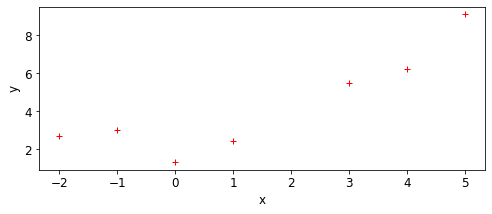

In [66]:
plot_points(points)

To fit a parabola to these points, we will build an `Expr` that represents the equation $\hat{y} = ax^2 + bx + c$, where $\hat{y}$ is the value of $y$ predicted by our parabola. 
If $\hat{y}$ is the predicted value, and $y$ is the observed value, to obtain a better prediction of the observations, we minimize the loss $L = (\hat{y} - y)^2$, that is, the square prediction error. 
Written out in detail, our loss is:

$$
    L \;=\; \left( y - \hat{y}\right)^ 2 \;=\; \left( y - (ax^2 + bx + c) \right)^2 \; .
$$

Here, $a, b, c$ are parameters that we need to tune to minimize the loss, and obtain a good fit between the parabola and the points. 
This tuning, or training, is done by repeating the following process many times:

* Zero the gradient
* For each point:
    * Set the values of x, y to the value of the point.
    * Compute the expression giving the loss.
    * Backpropagate.  This computes all gradients with respect to the loss, and in particular, the gradients of the coefficients $a, b, c$. 
* Update the coefficients $a, b, c$ by taking a small step in the direction of the negative gradient (negative, so that the loss decreases).

In [67]:
va = V(0.)
vb = V(0.)
vc = V(0.)
vx = V(0.)
vy = V(0.)

oy = va * vx * vx + vb * vx + vc

loss = (vy - oy) * (vy - oy)

Below, implement the "for each point" part of the above informal description.  Hint: this takes about 4-5 lines of code.

In [68]:
def fit(loss, points, params, delta=0.0001, num_iterations=4000):

    for iteration_idx in range(num_iterations):
        loss.zero_gradient()
        total_loss = 0.
        for x, y in points:
            ### You need to implement here the computaton of the 
            ### loss gradient for the point (x, y). 
            total_loss += loss.value
        if (iteration_idx + 1) % 100 == 0:
            print("Loss:", total_loss)
        for vv in params:
            vv.assign(vv.value - delta * vv.gradient)
    return total_loss

In [69]:
### Exercise: Implementation of `fit`

def fit(loss, points, params, delta=0.0001, num_iterations=4000):

    for iteration_idx in range(num_iterations):
        loss.zero_gradient()
        total_loss = 0.
        for x, y in points:
          vx.assign(x)
          vy.assign(y)
          loss.compute()
          loss.compute_gradient()
          total_loss += loss.value
        if (iteration_idx + 1) % 100 == 0:
            print("Loss:", total_loss)
        for vv in params:
            vv.assign(vv.value - delta * vv.gradient)
    return total_loss

Let's train the coefficients `va`, `vb`, `vc`: 

In [70]:
from nose.tools import assert_less

lv = fit(loss, points, [va, vb, vc])
assert_less(lv, 2.5)

Loss: 15.691480263172831
Loss: 13.628854145973717
Loss: 11.95710461470721
Loss: 10.577288435238483
Loss: 9.421709915417068
Loss: 8.442894724380599
Loss: 7.606627717852742
Loss: 6.887533665385938
Loss: 6.266252079473012
Loss: 5.727613949776414
Loss: 5.259450432876111
Loss: 4.851802101057622
Loss: 4.4963837663728965
Loss: 4.18621382152429
Loss: 3.9153507183966223
Loss: 3.6787002636071753
Loss: 3.471870598609928
Loss: 3.2910600093895632
Loss: 3.13296792199636
Loss: 2.9947227347465053
Loss: 2.8738222326925422
Loss: 2.768083672161589
Loss: 2.6756014919475786
Loss: 2.594711177586694
Loss: 2.523958185206276
Loss: 2.462071090153853
Loss: 2.4079383059994615
Loss: 2.360587848696134
Loss: 2.3191697158813342
Loss: 2.28294052348259
Loss: 2.251250098021605
Loss: 2.2235297678961032
Loss: 2.199282133501638
Loss: 2.1780721263873506
Loss: 2.1595191931327227
Loss: 2.1432904612844434
Loss: 2.1290947632296184
Loss: 2.1166774098449848
Loss: 2.105815619569577
Loss: 2.096314520528721


Let's display the parameter values after the training:

In [71]:
print("a:", va.value, "b:", vb.value, "c:", vc.value)

a: 0.2676897030023671 b: 0.09446139849938508 c: 1.9725828646266883


Let's display the points, along with the fitted parabola.

In [72]:
import numpy as np

def plot_points_and_y(points, vx, oy):
    fig, ax = plt.subplots()
    xs, ys = zip(*points)
    ax.plot(xs, ys, 'r+')
    x_min, x_max = np.min(xs), np.max(xs)
    step = (x_max - x_min) / 100
    x_list = list(np.arange(x_min, x_max + step, step))
    y_list = []
    for x in x_list:
        vx.assign(x)
        oy.compute()
        y_list.append(oy.value)
    ax.plot(x_list, y_list)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

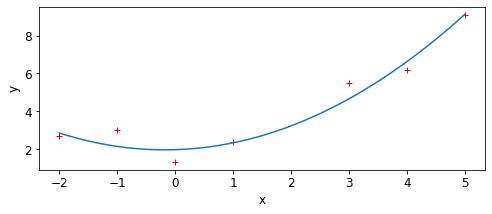

In [73]:
plot_points_and_y(points, vx, oy)

This looks like a good fit!

Note that if we chose too large a learning step, we would not converge to a solution.  A large step causes the parameter values to zoom all over the place, possibly missing by large amounts the (local) minima where you want to converge.  In the limit where the step size goes to 0, and the number of steps to infinity, you are guaranteed (if the function is differentiable, and some other hypotheses) converge to the minimum; the problem is that it would take infinitely long.  You will learn in a more in-depth ML class how to tune the step size.

In [74]:
# Let us reinitialize the variables.
va.assign(0)
vb.assign(0)
vc.assign(0)
# ... and let's use a big step size.
fit(loss, points, [va, vb, vc], delta=0.01, num_iterations=1000)

Loss: 7.445536528760376e+257
Loss: inf
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan


nan

A step size of 0.01 was enough to take us to infinity and beyond.

Let us now show you how to fit a simple linear regression: $y = ax + b$, so $L = (y - (ax + b))^2$. 

In [75]:
# Parameters
# Sometimes you have to be careful about initial values.
va = V(1.)
vb = V(1.)

# x and y
vx = V(0.)
vy = V(0.)

# Predicted y
oy = va * vx + vb

# Loss
loss = (vy - oy) * (vy - oy)

In [76]:
fit(loss, points, [va, vb])

Loss: 28.04911931725314
Loss: 24.56807140584221
Loss: 22.04737547646302
Loss: 20.018461554483544
Loss: 18.363064879989466
Loss: 17.010221159926804
Loss: 15.904419410376471
Loss: 15.000526654509262
Loss: 14.261674191105309
Loss: 13.657727388420048
Loss: 13.164054060381849
Loss: 12.760519585409948
Loss: 12.43066568540981
Loss: 12.161039167477448
Loss: 11.940643231055738
Loss: 11.760488960015408
Loss: 11.613228706940784
Loss: 11.492856417067383
Loss: 11.394462669488892
Loss: 11.314034444913947
Loss: 11.248291453438622
Loss: 11.194552346912685
Loss: 11.150625359329684
Loss: 11.114718914975501
Loss: 11.085368558461209
Loss: 11.061377226459106
Loss: 11.041766425106331
Loss: 11.025736321831346
Loss: 11.012633123936265
Loss: 11.00192241346032
Loss: 10.99316735077883
Loss: 10.986010857964564
Loss: 10.980161055254529
Loss: 10.975379356643991
Loss: 10.971470739082786
Loss: 10.968275788400177
Loss: 10.965664197548818
Loss: 10.963529451991706
Loss: 10.96178448547398
Loss: 10.960358128998926


10.960358128998926

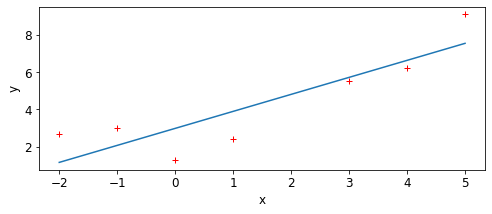

In [77]:
plot_points_and_y(points, vx, oy)

## Exercises

Using the method illustrated above, fit the following equations to our set of points.  Use `vx`, `xy` for $x$, $y$, and `va`, `vb`, `vc`, etc for the parameters.  This is important, or the tests won't pass.

$$
y = a^x + bx + c
$$

In [78]:
### Exercise: fit of y = a^x + bx + c

vx = V(0.)
vy = V(0.)
va = V(1.)
vb = V(0.)
vc = V(0.)
# Define below what is oy and loss. 
oy = va ** vx + vb * vx + vc
loss = (vy - oy)*(vy - oy)

fit(loss, points, [va, vb, vc])

Loss: 13.22031673565597
Loss: 11.141654640359056
Loss: 9.524337885770317
Loss: 8.258639654229485
Loss: 7.261959756098997
Loss: 6.472240243458916
Loss: 5.842777193129943
Loss: 5.338271943130829
Loss: 4.93188598839005
Loss: 4.603069161367653
Loss: 4.335966482106359
Loss: 4.118250607697591
Loss: 3.940264273483409
Loss: 3.794387517804188
Loss: 3.6745678050846706
Loss: 3.575968472470752
Loss: 3.494703513553483
Loss: 3.427635753770303
Loss: 3.3722219198375187
Loss: 3.326392689534276
Loss: 3.288459066630091
Loss: 3.2570387471581963
Loss: 3.2309978039038927
Loss: 3.2094042107284664
Loss: 3.191490593868335
Loss: 3.1766242293232927
Loss: 3.164282770875983
Loss: 3.1540345391718048
Loss: 3.1455224617311255
Loss: 3.1384509501803577
Loss: 3.1325751510442505
Loss: 3.127692122085746
Loss: 3.1236335760432823
Loss: 3.120259903985071
Loss: 3.117455245995913
Loss: 3.1151234209610212
Loss: 3.113184562377402
Loss: 3.111572335343445
Loss: 3.1102316326277197
Loss: 3.109116666132855


3.109116666132855

In [79]:
### Tests for convergence of fit of y = a^x + bx + c


Now, fit: 

$$
y = a \cdot 2^x + b \cdot 2^{-x} + c x^3 + d x^2 + e x + f
$$

Use a small enough step size, and a sufficient number of iterations, to obtain a final loss of no more than 2.5.

Hint: write `vx * vx * vx`, not `vx ** 3`, etc, since as currently written, the `**` operator cannot handle a negative basis.

In [80]:
### Exercise: fit of y = a 2^x + b 2^{-x} + c x^3 + d x^2 + e x + f
vx = V(0.)
vy = V(0.)
va = V(1.)
vb = V(1.)
vc = V(0.)
vd = V(0.)
ve = V(0.)
vf = V(0.)
# Define here what is oy and what is the loss.
oy = va* (2**vx)+vb*(2**-vx)+vc*(vx*vx*vx)+vd*(vx*vx)+ve*vx+vf
loss = (vy - oy)*(vy - oy)
fit(loss, points, [va, vb, vc, vd, ve, vf], delta=0.00002, num_iterations=35000)

Loss: 14.47308263741464
Loss: 13.149118394564304
Loss: 12.052269282606229
Loss: 11.119822299760546
Loss: 10.31298951008421
Loss: 9.606610841909317
Loss: 8.983438928103547
Loss: 8.43094997378422
Loss: 7.939549077723112
Loss: 7.501547014615207
Loss: 7.110565303579981
Loss: 6.761180362550861
Loss: 6.448702292740461
Loss: 6.169030495014693
Loss: 5.918554022346396
Loss: 5.694078743762034
Loss: 5.492771219838277
Loss: 5.3121135201238765
Loss: 5.149865618176149
Loss: 5.004033343775038
Loss: 4.872840629612138
Loss: 4.7547052230493065
Loss: 4.64821728657702
Loss: 4.552120462878798
Loss: 4.465295075834541
Loss: 4.386743201678053
Loss: 4.315575388373977
Loss: 4.2509988336505025
Loss: 4.192306857282233
Loss: 4.138869523607626
Loss: 4.0901252873179
Loss: 4.045573550136237
Loss: 4.0047680286611715
Loss: 3.9673108447394214
Loss: 3.9328472595138773
Loss: 3.901060980951364
Loss: 3.8716699823395846
Loss: 3.8444227760730754
Loss: 3.819095093124992
Loss: 3.795486924011447
Loss: 3.7734198818726346
Loss: 3.

2.379859342007634

In [81]:
### Tests for fit of  y = a 2^x + b 2^{-x} + c x^3 + d x^2 + e x + f


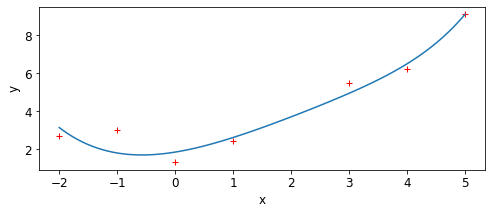

In [82]:
plot_points_and_y(points, vx, oy)